In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot
from pyshaper.utils.plot_utils import plot_event

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

2023-10-30 18:32:30.142236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Dataset

In [2]:
# Parameters 
R = 1
this_dir = ""
this_study = "cmsopendata"


dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 1000)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open

Max # of particles: 124


# Construct Train Step for N-Subjettiness

In [3]:
# Initializer
# import fastjet._pyjet  # noqa: F401

# from fastjet._pyjet import ClusterSequence, JetDefinition, PseudoJet

# import pyfjcore

from pyjet import cluster

def kT_N(events, N, R):

    jets = []

    for event in events:

        # Set up 4-vectors
        four_vectors = []
        for particle in event:
            four_vectors.append((particle[0], particle[1], particle[2], 0))
        four_vectors = np.array(four_vectors, dtype=[("pt", "f8"), ("eta", "f8"), ("phi", "f8"), ("mass", "f8")])

        # Cluster with kT (p = 1)
        sequence = cluster(four_vectors, R=R, p=1)
        subjets = sequence.exclusive_jets(N)

        output = np.zeros((N, 3))
        for i, subjet in enumerate(subjets):
            output[i,0] = subjet.pt
            output[i,1] = subjet.eta
            output[i,2] = subjet.phi


        # Normalize
        output[:,0] = np.nan_to_num(output[:,0] / np.sum(output[:,0]))

        jets.append(output)


    return np.array(jets)


In [4]:
from pyspecter.SpectralEMD_Helper import ds2_events1_spectral2
import jax.example_libraries.optimizers as jax_opt
from jax.example_libraries import optimizers
import jax
import tqdm


# Gradients
vmap_compute_spectral_representation = jax.vmap(compute_spectral_representation, in_axes = 0)
vmap_ds2_events1_spectral2 = jax.vmap(ds2_events1_spectral2)
ds2_events1_spectral2_gradients = grad(ds2_events1_spectral2, )
vmap_ds2_events1_spectral2_gradients = jax.vmap(ds2_events1_spectral2_gradients)


# Function to enforce normalization of energies
def project(events):

    temp = jnp.copy(events)
    zs = events[:,:,0]
    num_particles = events.shape[1]
    batch_size = events.shape[0]

    cnt_n = jnp.arange(num_particles)
    cnt_i = jnp.arange(batch_size)

    u = jnp.sort(zs, axis = -1)[:,::-1]
    v = (jnp.cumsum(u, axis = -1)-1) / (cnt_n + 1)
    w = v[cnt_i, jnp.sum(u > v, axis = -1) - 1]
    temp2 = temp.at[:,:,0].set(jnp.maximum(zs - w[:,None], 0))

    # temp = temp.at[:,:,0].set(jnp.maximum(temp[:,:,0], 0))
    # return temp

    return temp2

# For N-spronginess, the shape is just the params
def shape_from_params(params):
    return params


def initialize(events, N, seed):

    # new_events = jnp.ones((events.shape[0], N, 3)) / N
    # new_events = new_events.at[:,:,1:3].set(R/4 * jax.random.normal(seed, (N, 2)))
    # # new_events = new_events.at[:,0,1:3].set( (0,.000))
    # # new_events = new_events.at[:,1,1:3].set( (1,0))


    return kT_N(events, N, R)

def compute_N_spronginess(events, N, epochs = 100, learning_rate = 1e-2):
    
    # Get spectral representation of events:
    events_spectral = vmap_compute_spectral_representation(events)

    # Initialize events
    shape_events = initialize(events, N, seed = random.PRNGKey(0))

    
    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(shape_events)

    losses = np.zeros((epochs, events.shape[0]))


    for epoch in tqdm.tqdm(range(epochs)):


        params = get_params(opt_state)
        shape_events = shape_from_params(params)
        shape_events = project(shape_events)
        sEMDs, grads = train_step(epoch, events_spectral, shape_events)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMDs
        


    return jnp.min(losses, axis = 0), shape_events, losses

def replace_params_in_state(opt_state, new_params):
    if isinstance(opt_state, tuple) and len(opt_state) == 2 and isinstance(opt_state[0], dict):
        # This is the parameter tuple for Adam
        return (new_params, opt_state[1])
    elif isinstance(opt_state, tuple):
        # Unpack and modify recursively
        return tuple(replace_params_in_state(sub_state, new_params) for sub_state in opt_state)
    else:
        # Leaf node or unknown type, return unchanged
        return opt_state

@jax.jit
def train_step(epoch, spectral_events, shape_events):

    sEMDS = vmap_ds2_events1_spectral2(shape_events, spectral_events)
    grads = vmap_ds2_events1_spectral2_gradients(shape_events, spectral_events)
    return sEMDS, jnp.nan_to_num(grads)




100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s]


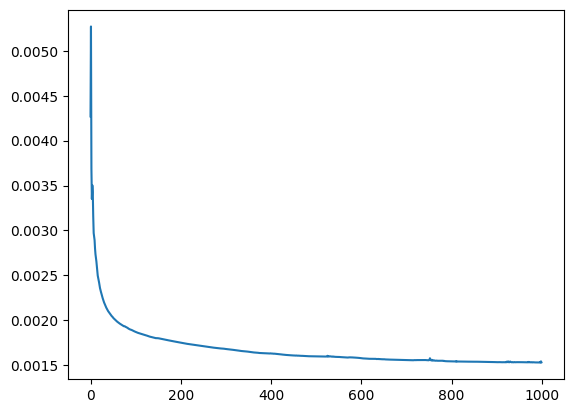

In [5]:
sEMDs, shape_events, losses = compute_N_spronginess(dataset, 3, epochs = 1000, learning_rate = 5e-2)

filename = f"{this_study}_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, sEMDs)


# plot the average loss per epoch
plt.plot(np.mean(losses, axis = -1))
# plt.yscale("log")

In [6]:
print(np.where(sEMDs < 0))

# print(shape_events[46])np.where(losses < 0)
print(project(np.array([shape_events[46],])))

(array([], dtype=int64),)
[[[ 0.9089139   0.023466   -0.00602036]
  [ 0.07901891 -0.01973944  0.03910105]
  [ 0.01206716  0.275596   -0.27100465]]]


# Closed Form Expressions

In [7]:
def theta(x):
    return x > 0


def find_omega12(spectral_events, two_E1E2):

    omega = spectral_events[:,0]
    two_EE = spectral_events[:,1]



    cumulative = jnp.cumsum(spectral_events[:,1], axis = -1)
    cumulative_exclusive = cumulative - spectral_events[:,1]
    total_energy = cumulative[-1]

    term1 = (two_EE) / two_E1E2
    theta1 = theta(two_E1E2 - total_energy + cumulative_exclusive)

    term2 = 1 - (total_energy - cumulative) / two_E1E2
    theta2a = 1 - theta1
    theta2b = theta(two_E1E2 - total_energy + cumulative)
    theta2 = theta2a * theta2b

    total = jnp.sum(omega * (term1 * theta1 + term2 * theta2), axis = -1)
    return total

vmap_find_omega12 = jax.vmap(jax.jit(find_omega12), in_axes = (0, None))

def closed_form_2_spronginess(events, levels = 50):

    two_E1E2 = np.linspace(0.0001, 1/2, levels)
    sEMDs = np.zeros((levels, events.shape[0]))

    spectral_events = vmap_compute_spectral_representation(events)


    for i in tqdm.tqdm(range(levels)):
        find_omega12 = vmap_find_omega12(spectral_events, two_E1E2[i])
        term_1 = np.sum(spectral_events[:,:,0]**2 * spectral_events[:,:,1] , axis = -1)
        term_2 = two_E1E2[i] * find_omega12**2

        sEMDs[i] = term_1 - term_2

    # Take the minimum over all levels
    return np.min(sEMDs, axis = 0)





In [8]:
closed_form_sEMDs = closed_form_2_spronginess(dataset, levels = 150)
print(closed_form_sEMDs)


filename = f"{this_study}_closed_form_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, closed_form_sEMDs)

100%|██████████| 150/150 [00:06<00:00, 23.75it/s]

[0.00827267 0.00511824 0.00759102 0.00494587 0.00253466 0.00479633
 0.00419618 0.00141754 0.01842209 0.00434787 0.00366078 0.00269205
 0.00761294 0.00640521 0.00561391 0.00818834 0.00178883 0.00295395
 0.0079845  0.0042058  0.00120286 0.0018327  0.00610295 0.00138028
 0.00378898 0.00259095 0.00374774 0.00779192 0.01161759 0.00335475
 0.00596609 0.00283128 0.00110292 0.00380869 0.00328572 0.00512482
 0.00246875 0.00249882 0.00274084 0.00369191 0.00257118 0.00402068
 0.00846068 0.0042033  0.00465873 0.00071543 0.00085599 0.01071146
 0.00119211 0.00549245 0.00226362 0.01317618 0.00211655 0.00330458
 0.01972324 0.00329887 0.00508182 0.00443028 0.00070562 0.00698975
 0.00536117 0.00184062 0.00636865 0.00230342 0.00436446 0.0037499
 0.00263551 0.00160797 0.00658362 0.00608408 0.00610122 0.00147882
 0.00280815 0.00342035 0.00177934 0.00646811 0.00412996 0.00453574
 0.00241635 0.00031167 0.00403592 0.00386789 0.004436   0.0060568
 0.00490578 0.00669585 0.00279261 0.0079659  0.00459258 0.006880

# SHAPER

In [9]:
# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# Generate new events

R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

events = []
for i in range(dataset.shape[0]):

    event = dataset[i]

    zs = event[:,0]
    points = event[:,1:3]

    events.append((points, zs))


# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["3-Subjettiness"]


# Collect our observables in one dictionary
observables = {}
observables["2-Subjettiness"] = _2subjettiness

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []


dataset_emds, dataset_params = shaper.calculate(events, epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
for j in range(dataset.shape[0]):
    e = dataset_params["2-Subjettiness"][j]["EMD"]
    EMDs.append(e)


EMDs = np.array(EMDs)

filename = f"{this_study}_shaper_EMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, EMDs)

Using CPU!
Observable: 2-Subjettiness Epoch 0 Mean Loss = 0.036959936729399484 Elapsed time = 3.569s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 1 Mean Loss = 0.036725214472971855 Elapsed time = 7.168s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 2 Mean Loss = 0.034947233077138665 Elapsed time = 10.750s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 3 Mean Loss = 0.03412269767839462 Elapsed time = 14.341s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 4 Mean Loss = 0.034361998211592436 Elapsed time = 18.036s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 5 Mean Loss = 0.03413831614237279 Elapsed time = 21.907s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 6 Mean Loss = 0.03368732822407037 Elapsed time = 25.773s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 7 Mean Loss = 0.03335490944632329 Elapsed time = 29.684s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 8 Mean Loss = 0.0332278762627393 E

# Plots

348


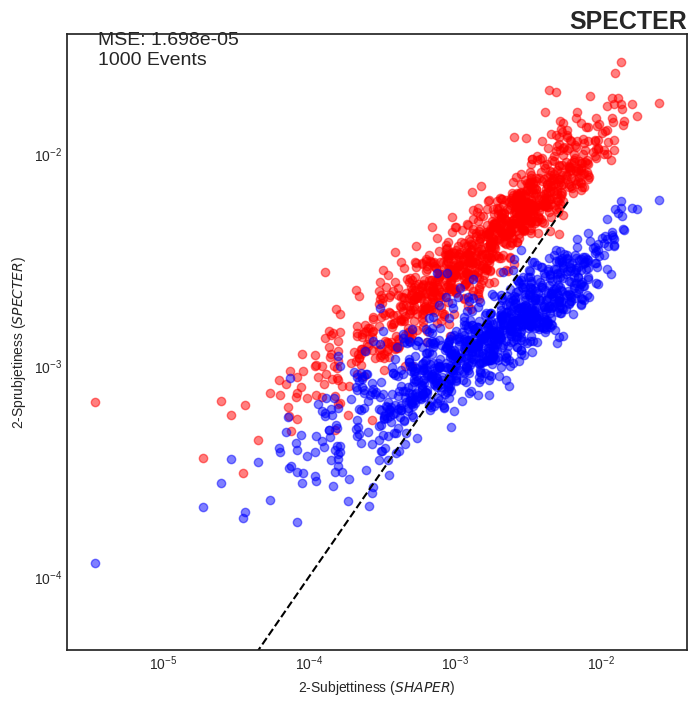

In [10]:
fig, ax = newplot()

# Load numpy data
sEMDs = np.load(os.path.join(this_dir, f"{this_study}_sEMDs.npy"))
closed_form_sEMDs = np.load(os.path.join(this_dir, f"{this_study}_closed_form_sEMDs.npy"))
EMDs = np.load(os.path.join(this_dir, f"{this_study}_shaper_EMDs.npy"))


plt.scatter(2 * EMDs**2, closed_form_sEMDs, color = "red", alpha = 0.5)
plt.scatter(2 * EMDs**2,  sEMDs, color = "blue", alpha = 0.5)



plt.xscale("log")
plt.yscale("log")
plt.xlabel("2-Subjettiness ($SHAPER$)")
plt.ylabel("2-Sprubjetiness ($SPECTER$)")

# Dashed line at y = x
x = np.linspace(0, np.max(sEMDs), 100)
plt.plot(x, x, linestyle = "--", color = "black")

# print the MSE in the top left
mse = np.mean((np.maximum(sEMDs, 0) - closed_form_sEMDs)**2)
plt.text(0.05, 0.95, "MSE: %.3e\n1000 Events" % mse, transform=ax.transAxes, fontsize=14,)

# print the percentage of events that differ by more than temp1%
diff = (sEMDs - (2 * EMDs**2)) / (2 * EMDs**2)
print(np.sum(diff > 0.10))
# plt.scatter(np.maximum(sEMDs, 0)[diff > 0.10], closed_form_sEMDs[diff > 0.10])

# ax.set_aspect('equal')

Text(0.5, 0, 'Fractional Error')

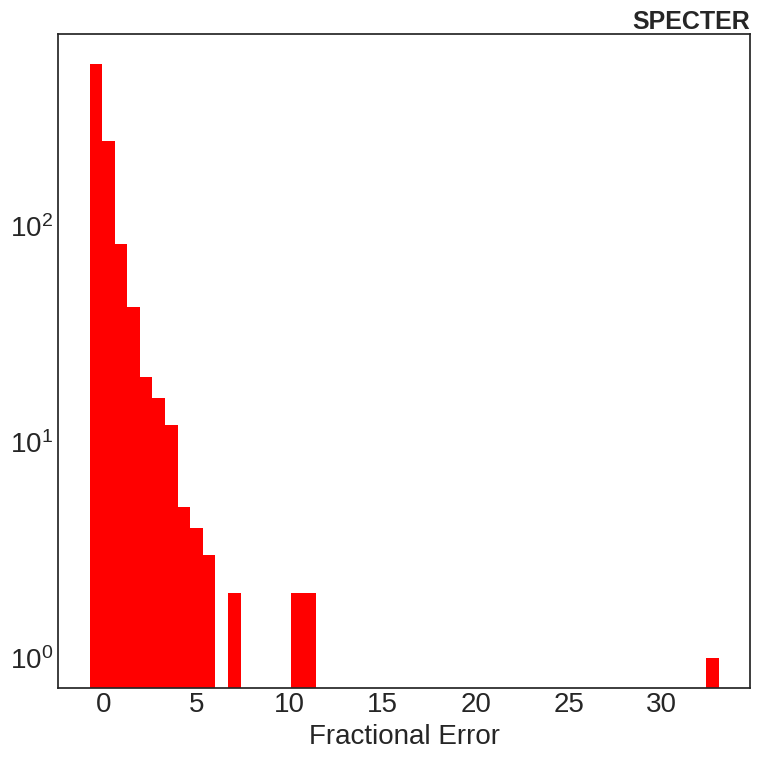

In [11]:
# Plot a histogram of the differences
fig, ax = newplot()
plt.hist(diff, bins = 50 )

# plt.xscale("log")
plt.yscale("log")

plt.xlabel("Fractional Error")
